### **MNIST 데이터 이해하기**

MNIST는 숫자 0 ~ 9까지의 이미지로 구성된 손글씨 데이터셋임

과거 우체국에서 편지의 우편번호를 인식하기 위해 만들어진 훈련 데이터임

총 60,000개의 훈련 데이터와 레이블, 총 10,000개의 테스트 데이터와 레이블로 구성됨

레이블은 0 ~ 9 까지 총 10개임

### MNIST 문제 예시

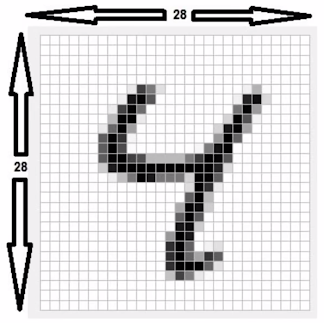

다음은 28 x 28 픽셀 크기의 이미지다

28 x 28 = 784 픽셀이므로 각 이미지를 총 784개의 원소를 가진 벡터화 해야함

In [ ]:
# 다음과 같은 식으로 벡터화할 수 있음음

# for X, Y in data_loader:
#     x = X.view(-1, 28*28)

---
### **torchvision**

torchvision은 유명한 데이터셋들, 유명한 모델들, 일반적인 이미지 전처리 도구들을 포함하고 있는 패키지임

---
### **분류기 구현을 위한 사전 설정**

In [10]:
# 환경 설정

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [4]:
# 현재 환경에서 GPU연산이 가능하면 GPU, 아니면 CPU 연산으로 설정

USE_CUDA = torch.cuda.is_available() # 가능하면 True, 아니면 False
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다: ", device)

# gpu 사용시 pytorch torchvision torchaudio cuda의 버전을 맞춰줘야 함
print(torch.__version__)

다음 기기로 학습합니다:  cuda
2.3.0+cu121


In [5]:
# for reproducibility

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [6]:
# hyperparameters

training_epochs = 15
batch_size = 100

---
### **Embody MNIST Classifier**

In [7]:
# MNIST dataset

mnist_train = dsets.MNIST(root='MNIST_data/', # 데이터 저장 경로 지정
                          train=True, # 훈련 데이터 여부
                          transform=transforms.ToTensor(), # 파이토치 텐서로 변환
                          download=True) # 해당 경로에 데이터 다운로드 여부부

mnist_test = dsets.MNIST(root="MNIST_data/",
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

Failed to download (trying next):
<urlopen error [Errno 11001] getaddrinfo failed>



100.0%


Extracting MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to MNIST_data/MNIST\raw

Failed to download (trying next):
<urlopen error [Errno 11001] getaddrinfo failed>



100.0%


Extracting MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw

Failed to download (trying next):
<urlopen error [Errno 11002] getaddrinfo failed>



100.0%


Extracting MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST_data/MNIST\raw

Failed to download (trying next):
<urlopen error [Errno 11002] getaddrinfo failed>



100.0%

Extracting MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw



In [12]:
# dataset loader

data_loader = DataLoader(dataset=mnist_train, # 위에서 다운받은 데이터셋셋
                         batch_size=batch_size, # 배치 사이즈는 100
                         shuffle=True, # 매 에포크마다 미니배치를 섞을 것인지
                         drop_last=True) # 마지막 배치를 버릴 것인지

**drop_last를 쓰는 이유**

마지막 배치란 1000개의 데이터를 배치크기 128개로 돌린다고 했을 때

1000을 128로 나누면 104가 나옴

이를 마지막 배치라고 함

다른 배치들보다 데이터 개수가 적은 마지막 배치를 경사 하강법에 사용시

마지막 배치가 상대적으로 과대 평가되는 현상을 막아줄 수 있음

In [13]:
# 모델 설계

# MNIST data image of shape 28 * 28 = 784

# input_dim, output_dim, bias
linear = nn.Linear(784, 10, bias=True).to(device)

to() 는 연산을 어디서 할지 정함

즉, 모델의 매개변수를 지정한 장치의 메모리로 보냄

CPU를 사용할 때는 필요없지만 GPU를 사용하려면 to('cuda')가 꼭 필요함

bias는 편향 b를 사용할 것인지 정함

True가 기본값임

In [14]:
# Cost Function and Optimizer

criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 soft 함수를 포함
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [17]:
for epoch in range(training_epochs):
    avg_cost = 0 # epoch 동안의 평균 비용
    total_batch = len(data_loader) # epoch 당 수행할 batch 수

    for X, Y in data_loader: # 데이터를 반복적으로 제공해주는 data_loader
        
        # batch_size 가 100이므로 X는 (100, 784) 크기의 텐서가 됨
        # -1 : 너가 알아서 맞춰줘!
        X = X.view(-1, 28 * 28).to(device)

        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수
        Y = Y.to(device)
        
        optimizer.zero_grad() # optimizer의 기울기 정보 초기화
        hypothesis = linear(X) # 모델의 가설 계산(순전파)
        cost = criterion(hypothesis, Y) # 예측값과 실제 레이블 Y 간의 비용 계산
        cost.backward() # 역전파 수행하고 기울기 계산
        optimizer.step() # 모델 파라미터(가중치, 편향) 업데이트

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.272883654
Epoch: 0002 cost = 0.271629602
Epoch: 0003 cost = 0.270609796
Epoch: 0004 cost = 0.269295007
Epoch: 0005 cost = 0.268277347
Epoch: 0006 cost = 0.267255455
Epoch: 0007 cost = 0.266613454
Epoch: 0008 cost = 0.265661418
Epoch: 0009 cost = 0.264922321
Epoch: 0010 cost = 0.263888717
Epoch: 0011 cost = 0.263269812
Epoch: 0012 cost = 0.262586147
Epoch: 0013 cost = 0.261751652
Epoch: 0014 cost = 0.261135817
Epoch: 0015 cost = 0.260536909
Learning finished


Accuracy:  0.8704999685287476
Label:  5
Prediction:  8


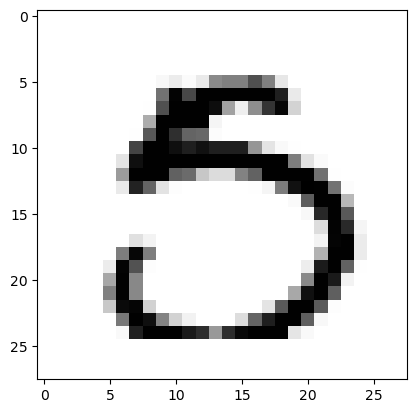

In [25]:
# 테스트 데이터를 사용하여 모델 테스트

with torch.no_grad(): # torch.no_grad()-> gradient 계산 안함
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)


    prediction = linear(X_test) # 학습된 모델에 입력데이터를 전달한 결과(예측값), 출력은 각 클래스에 대한 점수 형태
    correct_prediction = torch.argmax(prediction, 1) == Y_test # 가장 높은 클래스의 값이 실제값이랑 같으면 True
    accuracy = correct_prediction.float().mean() # 정답률 계산산
    print('Accuracy: ', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r+1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r+1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r+1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()